# Clustering based on Demographics

Using the cleaned data from the customer csv file, I added city population, latitude and longitude features to the table, then dropped the columns related to address. The population and coordinates gave me numerical features that captured relevant distinctions between different locations. I also dropped customer id and name as they would not be useful in the model.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA


In [3]:
cust_df = pd.read_csv('clean_data/customer_df_clean.csv')
cust_df.head()

,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,first_name,last_name,street_nbr,street_name,postal_code,city_name,state_code
0,1362691,26150,46,5,1,M,2,,Donald ...,Marek ...,8298,Second ...,89194,Las Vegas,NV
1,1362487,6605,71,1,0,M,2,,ChingDyi ...,Moussavi ...,10603,Daffodil ...,90159,Los Angeles,CA
2,1363160,18548,38,8,0,F,1,,Rosa ...,Johnston ...,8817,Figueroa ...,90024,Los Angeles,CA
3,1362752,47668,54,3,0,F,1,,Lisa ...,Martin ...,676,Humble ...,90172,Los Angeles,CA
4,1362548,44554,59,9,2,F,4,,Barbara ...,O'Malley ...,6578,C ...,10138,New York City,NY


### Feature Engineering

In [7]:
cust_df['state_code']=cust_df['state_code'].str.strip()
cust_df['city_name'] = cust_df['city_name'].str.strip()

In [9]:
prepped_df = cust_df.drop(columns=['cust_id', 'name_prefix', 'first_name', 'last_name', 'street_nbr', 'street_name', 'postal_code'])
prepped_df.head()

,income,age,years_with_bank,nbr_children,gender,marital_status,city_name,state_code
0,26150,46,5,1,M,2,Las Vegas,NV
1,6605,71,1,0,M,2,Los Angeles,CA
2,18548,38,8,0,F,1,Los Angeles,CA
3,47668,54,3,0,F,1,Los Angeles,CA
4,44554,59,9,2,F,4,New York City,NY


In [13]:
prepped_df['gender'].replace({'M ': 1, 'F ':0}, inplace=True)

In [15]:
population_dict = {'Las Vegas': 258295,
 'Los Angeles': 3485398,
 'New York City': 7322564,
 'Chicago': 2783726,
 'Honolulu': 365272,
 'Washington': 606900,
 'Houston': 1630553,
 'San Francisco': 753959,
 'Philadelphia': 1585577,
 'Portland': 437319,
 'Riverside': 226505,
 'Toledo': 332943,
 'Seattle': 516259,
 'Sacramento': 369365,
 'Newark': 275221,
 'Indianapolis': 731327,
 'Rochester': 231636,
 'Denver': 467610,
 'Milwaukee': 628088,
 'Detroit': 1027974,
 'Omaha': 335795,
 'Tucson': 405390,
 'Cleveland': 505616,
 'San Jose': 782248,
 'Minneapolis': 368383,
 'Memphis': 610337,
 'Long Beach': 429433,
 'Norfolk': 261229,
 'Austin': 465622,
 'Pittsburgh': 369879,
 'San Diego': 1110549,
 'Miami': 358458,
 'Nashville': 488374,
 'Oakland': 372242,
 'St Paul': 272235,
 'Anaheim': 266406,
 'Baltimore': 736014,
 'Corpus Christi': 257453,
 'St Louis': 396685,
 'Phoenix': 983403,
 'New Orleans': 496938,
 'El Paso': 515342,
 'Lexington': 225366,
 'Kansas City': 435146,
 'Oklahoma City': 444719,
 'Tulsa': 367302,
 'Louisville': 369063,
 'Dallas': 1006877,
 'Cincinnati': 364040,
 'Virginia Beach': 393069,
 'Dayton': 182044,
 'Fresno': 354202,
 'San Antonio': 935933,
 'Columbus': 632910,
 'Santa Ana': 293742,
 'Boston': 574283,
 'Mesa': 288091,
 'Jacksonville': 635230,
 'Fort Worth': 447619,
 'Atlanta': 394017,
 'Wichita': 304011,
 'Tampa': 280015,
 'Charlotte': 395934,
 'Albuquerque': 384736,
 'Jersey City': 228537,
 'Birmingham': 265968,
 'Colorado Springs': 281140,
 'Arlington': 261721,
 'Buffalo': 328123}

In [4]:
import requests
url = 'https://developers.google.com/public-data/docs/canonical/states_csv'
data_url = requests.get(url)
body= data_url.text
page = pd.read_html(body)
statecoord_df = page[0]
statecoord_df.head()

,state,latitude,longitude,name
0,AK,63.588753,-154.493062,Alaska
1,AL,32.318231,-86.902298,Alabama
2,AR,35.201050,-91.831833,Arkansas
3,AZ,34.048928,-111.093731,Arizona
4,CA,36.778261,-119.417932,California


In [5]:
statecoord_df.drop(columns='name', inplace=True)
statecoord_df.rename(columns={'state':'state_code'}, inplace=True)

In [16]:
prepped_df['population'] = prepped_df['city_name'].map(population_dict)
prepped_df = pd.merge(prepped_df, statecoord_df, how='left', on='state_code')
prepped_df.head()

,income,age,years_with_bank,nbr_children,gender,marital_status,city_name,state_code,population,latitude,longitude
0,26150,46,5,1,1,2,Las Vegas,NV,258295,38.802610,-116.419389
1,6605,71,1,0,1,2,Los Angeles,CA,3485398,36.778261,-119.417932
2,18548,38,8,0,0,1,Los Angeles,CA,3485398,36.778261,-119.417932
3,47668,54,3,0,0,1,Los Angeles,CA,3485398,36.778261,-119.417932
4,44554,59,9,2,0,4,New York City,NY,7322564,43.299428,-74.217933


In [19]:
prepped_df[prepped_df['latitude'].isna()]

,income,age,years_with_bank,nbr_children,gender,marital_status,city_name,state_code,population,latitude,longitude
33,36330,46,6,1,1,2,Omaha,NB,335795,NaN,NaN
127,13811,50,0,0,0,3,Omaha,NB,335795,NaN,NaN
380,20179,49,9,1,0,2,Omaha,NB,335795,NaN,NaN


In [20]:
prepped_df['latitude'].fillna(41.492537, inplace=True)
prepped_df['longitude'].fillna(-99.901813, inplace=True)
prepped_df.isna().sum()

income             0
age                0
years_with_bank    0
nbr_children       0
gender             0
marital_status     0
city_name          0
state_code         0
population         0
latitude           0
longitude          0
dtype: int64

In [22]:
prepped_df.drop(columns=['state_code', 'city_name'], inplace=True)
prepped_df.head()

,income,age,years_with_bank,nbr_children,gender,marital_status,population,latitude,longitude
0,26150,46,5,1,1,2,258295,38.802610,-116.419389
1,6605,71,1,0,1,2,3485398,36.778261,-119.417932
2,18548,38,8,0,0,1,3485398,36.778261,-119.417932
3,47668,54,3,0,0,1,3485398,36.778261,-119.417932
4,44554,59,9,2,0,4,7322564,43.299428,-74.217933


### Scaling and Clustering

In [33]:
scaler = StandardScaler().set_output(transform='pandas')
scaled_df = scaler.fit_transform(prepped_df)
scaled_df.head()

,income,age,years_with_bank,nbr_children,gender,marital_status,population,latitude,longitude
0,0.154185,0.184312,0.408539,0.258591,1.127172,0.132149,-0.746010,0.160190,-1.012863
1,-0.726524,1.493070,-1.087435,-0.648298,1.127172,0.132149,0.642623,-0.255584,-1.172784
2,-0.188366,-0.234490,1.530520,-0.648298,-0.887176,-0.989614,0.642623,-0.255584,-1.172784
3,1.123798,0.603115,-0.339448,-0.648298,-0.887176,-0.989614,0.642623,-0.255584,-1.172784
4,0.983479,0.864867,1.904514,1.165479,-0.887176,2.375675,2.293769,1.083776,1.237857


c:\Users\HP USER\anaconda3\envs\lhl_data\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP USER\anaconda3\envs\lhl_data\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\HP USER\anaconda3\envs\lhl_data\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP USER\anaconda3\envs\lhl_data\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks t

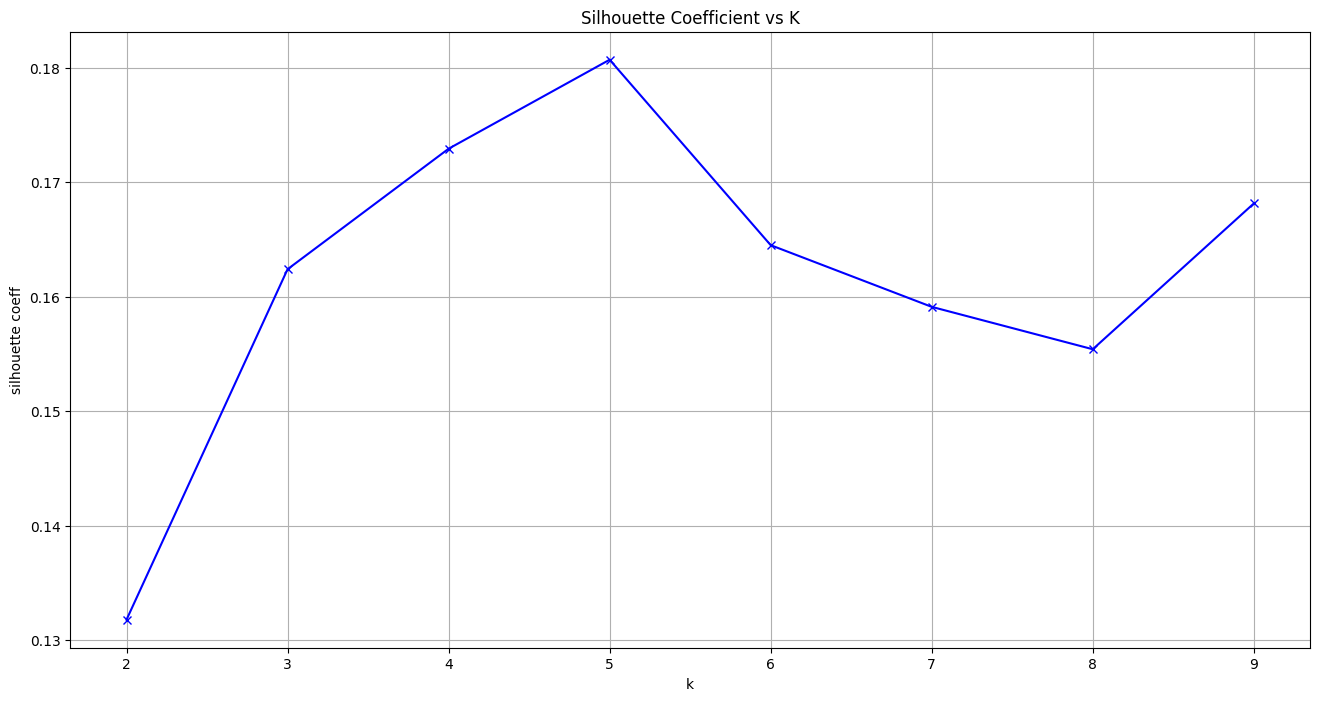

In [36]:
# check silhouett score for k value
from sklearn.metrics import silhouette_score

silhouettes = []
K = range(2, 10)
for k in K:
    kmeanModel= KMeans(n_clusters=k)
    kmeanModel.fit(scaled_df)
    label=kmeanModel.predict(scaled_df)
    silhouettes.append(silhouette_score(scaled_df, label))
# plot silhouette
plt.figure(figsize=(16,8))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette coeff')
plt.title('Silhouette Coefficient vs K')
plt.grid()
plt.show()

In [43]:
# apply KMeans model with 5 clusters
model = KMeans(5)
model.fit(scaled_df)

df_with_clusters = cust_df.copy()
df_with_clusters['label'] = model.predict(scaled_df)
df_with_clusters.head()

c:\Users\HP USER\anaconda3\envs\lhl_data\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP USER\anaconda3\envs\lhl_data\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,first_name,last_name,street_nbr,street_name,postal_code,city_name,state_code,label
0,1362691,26150,46,5,1,M,2,,Donald ...,Marek ...,8298,Second ...,89194,Las Vegas,NV,4
1,1362487,6605,71,1,0,M,2,,ChingDyi ...,Moussavi ...,10603,Daffodil ...,90159,Los Angeles,CA,4
2,1363160,18548,38,8,0,F,1,,Rosa ...,Johnston ...,8817,Figueroa ...,90024,Los Angeles,CA,2
3,1362752,47668,54,3,0,F,1,,Lisa ...,Martin ...,676,Humble ...,90172,Los Angeles,CA,4
4,1362548,44554,59,9,2,F,4,,Barbara ...,O'Malley ...,6578,C ...,10138,New York City,NY,1


c:\Users\HP USER\anaconda3\envs\lhl_data\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


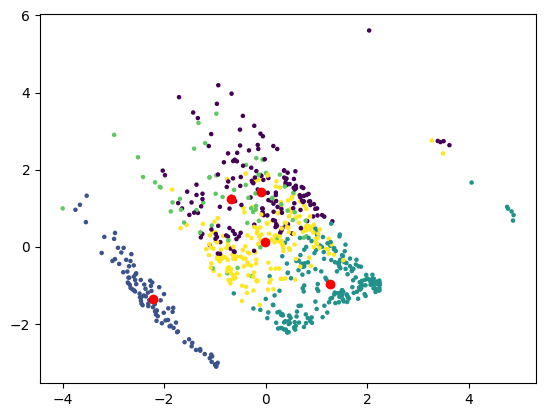

In [44]:
# perform PCA for visualization
pca = PCA(n_components=2).set_output(transform='pandas')
df_pca = pca.fit_transform(scaled_df)

df_pca_with_clusters = df_pca.copy()
df_pca_with_clusters
df_pca_with_clusters['label'] = df_with_clusters['label']

df_pca_with_clusters
pca_centroids = pca.transform(model.cluster_centers_)

plt.scatter(df_pca_with_clusters['pca0'], df_pca_with_clusters['pca1'], c=df_pca_with_clusters['label'], s=5)
plt.scatter(pca_centroids['pca0'], pca_centroids['pca1'], c='red')


This doesn't look great. Below is Hierarchical Clustering

In [45]:
def plotDendrogram(X, method ='ward'):
    dendrogram = sch.dendrogram(sch.linkage(X, method=method))
    plt.title("Dendrogram")
    plt.ylabel("Euclidean distances")
    plt.xlabel('Points')
    plt.show()

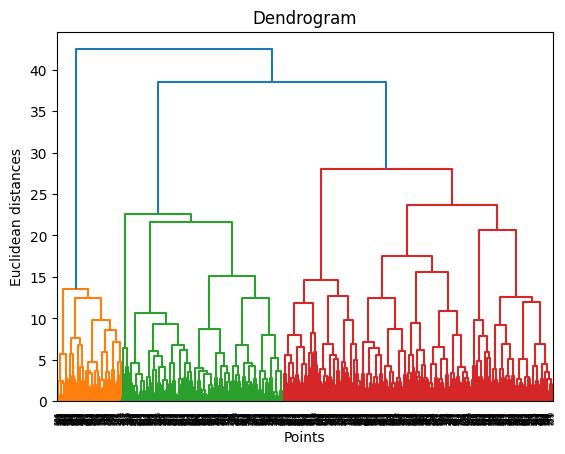

In [46]:
plotDendrogram(scaled_df)

In [79]:
ac = AgglomerativeClustering(affinity='euclidean',
                             linkage='ward',
                             n_clusters=3)
y_hc = ac.fit_predict(scaled_df)

c:\Users\HP USER\anaconda3\envs\lhl_data\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [80]:
df_with_clusters = cust_df.copy()
df_with_clusters['label'] = y_hc

df_pca = pca.fit_transform(scaled_df)
df_pca_with_clusters = df_pca.copy()
df_pca_with_clusters['label'] = df_with_clusters['label']
df_pca_with_clusters.head()

,pca0,pca1,label
0,0.500079,0.896887,0
1,0.221577,0.168711,0
2,0.981391,-0.576550,0
3,0.345776,-0.030265,2
4,-3.661046,1.091354,1


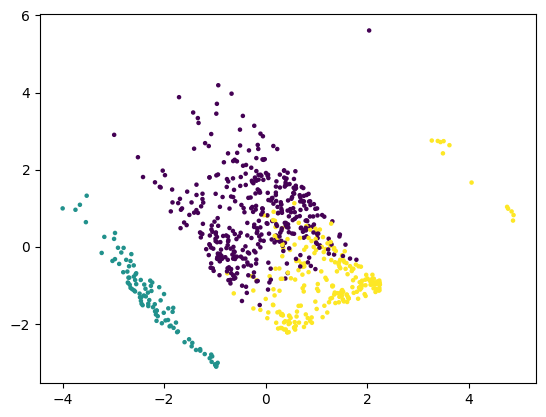

In [81]:
plt.scatter(df_pca_with_clusters['pca0'], df_pca_with_clusters['pca1'], c=df_pca_with_clusters['label'], s=5,)

In [82]:
cluster_0_means = prepped_df[df_with_clusters['label'] == 0].mean()
cluster_1_means = prepped_df[df_with_clusters['label'] == 1].mean()
cluster_2_means = prepped_df[df_with_clusters['label'] == 2].mean()


means = pd.DataFrame([cluster_0_means, cluster_1_means, cluster_2_means])
means

,income,age,years_with_bank,nbr_children,gender,marital_status,population,latitude,longitude
0,28870.366995,51.559113,4.108374,1.110837,0.453202,2.290640,1.147202e+06,37.710519,-99.257269
1,24621.244898,44.642857,3.908163,0.632653,0.448980,1.897959,7.322564e+06,43.299428,-74.217933
2,11702.777778,26.436214,3.572016,0.086420,0.415638,1.193416,1.253633e+06,36.416124,-103.732124


That looked better. What about DBSCAN?

In [76]:
db = DBSCAN(eps=1.5, min_samples=4, metric='euclidean')
y_db = db.fit_predict(scaled_df)

In [77]:
df_with_clusters = cust_df.copy()
df_with_clusters['label'] = y_db

df_pca = pca.fit_transform(scaled_df)
df_pca_with_clusters = df_pca.copy()
df_pca_with_clusters['label'] = df_with_clusters['label']
df_pca_with_clusters.head()

,pca0,pca1,label
0,0.500079,0.896887,0
1,0.221577,0.168711,-1
2,0.981391,-0.576550,1
3,0.345776,-0.030265,1
4,-3.661046,1.091354,-1


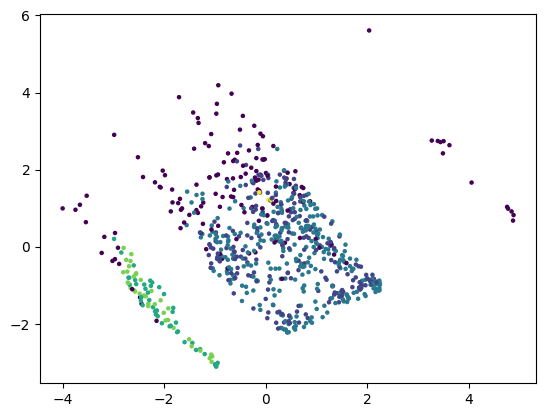

In [78]:
plt.scatter(df_pca_with_clusters['pca0'], df_pca_with_clusters['pca1'], c=df_pca_with_clusters['label'], s=5,)

Nope. Looks like hierarchical is best.

### Radar Chart

In [86]:
df_with_clusters['label'].value_counts()

label
0    406
2    243
1     98
Name: count, dtype: int64

In [87]:
means

,income,age,years_with_bank,nbr_children,gender,marital_status,population,latitude,longitude
0,28870.366995,51.559113,4.108374,1.110837,0.453202,2.290640,1.147202e+06,37.710519,-99.257269
1,24621.244898,44.642857,3.908163,0.632653,0.448980,1.897959,7.322564e+06,43.299428,-74.217933
2,11702.777778,26.436214,3.572016,0.086420,0.415638,1.193416,1.253633e+06,36.416124,-103.732124


Need to create a standard 1-5 scale for these cluster means based on ranges of data

In [93]:
prepped_df.describe()

,income,age,years_with_bank,nbr_children,gender,marital_status,population,latitude,longitude
count,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,7.470000e+02,747.000000,747.000000
mean,22728.281124,42.479250,3.907631,0.714859,0.440428,1.882195,1.991979e+06,38.022668,-97.427999
std,22207.221405,19.114879,2.675634,1.103410,0.496771,0.892051,2.325499e+06,4.872129,18.762770
min,0.000000,13.000000,0.000000,0.000000,0.000000,1.000000,1.820440e+05,19.898682,-155.665857
25%,7118.500000,28.000000,2.000000,0.000000,0.000000,1.000000,3.959340e+05,35.759573,-119.417932
50%,17242.000000,42.000000,4.000000,0.000000,0.000000,2.000000,7.360140e+05,37.431573,-94.685900
75%,31338.000000,56.000000,6.000000,1.000000,1.000000,2.000000,2.783726e+06,41.203322,-81.515754
max,144157.000000,89.000000,9.000000,5.000000,1.000000,4.000000,7.322564e+06,47.751074,-71.382437


In [95]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,5)).set_output(transform='pandas')
score_df = scaler.fit_transform(prepped_df)
score_df.describe()

,income,age,years_with_bank,nbr_children,gender,marital_status,population,latitude,longitude
count,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000
mean,0.788317,1.939424,2.170906,0.714859,2.202142,1.470326,1.267369,3.253578,3.454882
std,0.770244,1.257558,1.486463,1.103410,2.483856,1.486752,1.628382,0.874634,1.113076
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.246901,0.986842,1.111111,0.000000,0.000000,0.000000,0.149772,2.847312,2.150359
50%,0.598029,1.907895,2.222222,0.000000,0.000000,1.666667,0.387906,3.147466,3.617554
75%,1.086940,2.828947,3.333333,1.000000,5.000000,1.666667,1.821773,3.824562,4.398855
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [98]:
score_df_with_clusters = score_df.copy()
score_df_with_clusters['label'] = y_hc

cluster_0_mean_score = score_df[score_df_with_clusters['label'] == 0].mean()
cluster_1_mean_score = score_df[score_df_with_clusters['label'] == 1].mean()
cluster_2_mean_score = score_df[score_df_with_clusters['label'] == 2].mean()


mean_scores = pd.DataFrame([cluster_0_mean_score, cluster_1_mean_score, cluster_2_mean_score])
mean_scores

,income,age,years_with_bank,nbr_children,gender,marital_status,population,latitude,longitude
0,1.001352,2.536784,2.282430,1.110837,2.266010,2.151067,0.675832,3.197542,3.346363
1,0.853973,2.081767,2.171202,0.632653,2.244898,1.496599,5.000000,4.200850,4.831788
2,0.405904,0.883961,1.984454,0.086420,2.078189,0.322359,0.750358,2.965175,3.080899


In [102]:
categories = mean_scores.columns.tolist()

fig = go.Figure()

for i in mean_scores.index:
    df = mean_scores.loc[i].T
    values = df.values.tolist()
    fig.add_trace(go.Scatterpolar(
      r=values,
      theta=categories,
      fill='toself',
      name = i
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 5]
    )),
  showlegend=False
)

fig.show()